# Supplementary Figure S1 - Yeast GI Score Matrix

Depth-dependent post hoc enrichment-based annotation of a hierarchically clustered _Saccharomyces cerevisiae_ genetic interaction (GI) score matrix.

In [1]:
# Enable inline plotting for notebooks
%matplotlib inline

## Load Inputs

Load GO BP annotations and the GI score matrix used for clustering and enrichment, then build a row-level essentiality mapping.

GO BP terms loaded: 1,095
Min term size: 5
Max term size: 243
Unique ORFs across all terms: 4,927


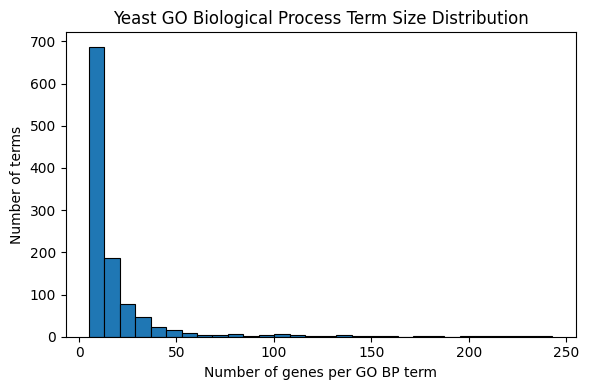

In [ ]:
# Loads pre-filtered GO BP annotations and visualizes term sizes.
import json
from pathlib import Path

import matplotlib.pyplot as plt

DATA_DIR = Path("data/yeast")
GO_BP_PATH = DATA_DIR / "go_bp_name_to_orfs.json"

# Load GO Biological Process term -> ORF mapping (already filtered upstream)
with GO_BP_PATH.open("r", encoding="utf-8") as fh:
    go_bp = json.load(fh)

# Compute term sizes and global ORF coverage
term_sizes = [len(set(orfs)) for orfs in go_bp.values()]
all_orfs = {orf for orfs in go_bp.values() for orf in orfs}

# Summary statistics reported in the manuscript
print(f"GO BP terms loaded: {len(term_sizes):,}")
print(f"Min term size: {min(term_sizes)}")
print(f"Max term size: {max(term_sizes)}")
print(f"Unique ORFs across all terms: {len(all_orfs):,}")

# Histogram of GO BP term sizes
plt.figure(figsize=(6, 4))
plt.hist(
    term_sizes,
    bins=30,
    edgecolor="black",
    linewidth=0.8,
)
plt.xlabel("Number of genes per GO BP term")
plt.ylabel("Number of terms")
plt.title("Yeast GO Biological Process Term Size Distribution")
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd

MATRIX_PATH = DATA_DIR / "gi_score_sampled.tsv"

# Load GI score matrix (ORF x ORF)
DF_GI_SCORE = pd.read_csv(
    MATRIX_PATH,
    sep="\t",
    index_col=0,
)

# Sanity checks
print(f"Matrix shape: {DF_GI_SCORE.shape[0]:,} × {DF_GI_SCORE.shape[1]:,}")
print(f"Row/column labels identical: {DF_GI_SCORE.index.equals(DF_GI_SCORE.columns)}")
print(f"Value range: [{DF_GI_SCORE.min().min():.3f}, {DF_GI_SCORE.max().max():.3f}]")

display(DF_GI_SCORE.head())

Matrix shape: 1,142 × 1,142
Row/column labels identical: False
Value range: [-1.095, 1.478]


,YNL243W,YMR030W-A,YLR275W,YDR302W,YJL031C,YGL116W,YPL069C,YEL034W,YLR310C,YLR268W,...,YLL023C,YNR010W,YGL170C,YGR245C,YGL216W,YER156C,YCR003W,YGR197C,YMR033W,YJR140C
Query Gene,,,,,,,,,,,,,,,,,,,,,
YNL243W,0.0000,0.0000,0.0,-0.3112,0.0000,0.0961,-0.5364,0.0000,0.1149,0.0000,...,0.0000,0.0,0.0,0.33430,0.0000,0.00000,0.0,0.0,0.0000,0.0000
YMR030W-A,0.0000,0.0000,0.0,-0.2963,0.0000,0.0000,0.0491,0.0000,0.0000,-0.0702,...,0.0000,0.0,0.0,0.00000,0.0000,0.00000,0.0,0.0,0.0000,0.0000
YLR275W,0.0000,0.0000,0.0,0.0000,0.0000,-0.1608,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.0,0.14550,-0.1491,0.00000,0.0,0.0,0.3374,-0.4909
YDR302W,-0.3112,-0.2963,0.0,0.0000,0.2026,-0.0654,0.1986,0.2527,0.1218,0.0000,...,-0.5064,0.0,0.0,-0.11140,0.0000,0.00000,0.0,0.0,-0.3312,0.0000
YJL031C,0.0000,0.0000,0.0,0.2026,0.0000,0.1558,-0.5182,0.0000,0.0000,-0.2886,...,0.0000,0.0,0.0,0.20115,0.0000,0.10275,0.0,0.0,-0.1536,0.0000


In [4]:
# Authoritative gene order from matrix.
genes = DF_GI_SCORE.index

# Helper functions for the essentiality row-level bar.


def build_binary_gene_map(
    genes,
    positive_set,
    pos_label,
    neg_label,
):
    """Return {gene -> pos_label/neg_label} based on membership in positive_set."""
    return {gene: (pos_label if gene in positive_set else neg_label) for gene in genes}


def load_essential_orfs(path):
    """Load one ORF per line."""
    return {line.strip() for line in path.read_text().splitlines() if line.strip()}


def map_essential_genes(genes, essential_orfs):
    """Map genes to essential/nonessential labels and return label->color mapping."""
    gene_map = build_binary_gene_map(
        genes,
        essential_orfs,
        pos_label="essential",
        neg_label="nonessential",
    )

    colors = {
        "essential": "#d73027",  # red
        "nonessential": "black",
    }

    return gene_map, colors


# Build essential/nonessential mapping.
essential_path = DATA_DIR / "yeast_essential_orfs.txt"
essential_orfs = load_essential_orfs(essential_path)
gene_essential_map, gene_essential_colors = map_essential_genes(genes, essential_orfs)

print("Total genes:", len(genes))
print(
    "Essential in matrix:",
    sum(v == "essential" for v in gene_essential_map.values()),
)

Total genes: 1142
Essential in matrix: 510


## Cluster, Enrich, and Filter

Run hierarchical clustering, evaluate enrichment across dendrogram-defined clusters, and filter by Benjamini-Hochberg FDR (`qval <= 0.05`).

In [5]:
from himalayas import Matrix, Annotations, Analysis

LINKAGE_THRESHOLD = 8

# Build core objects
matrix = Matrix(DF_GI_SCORE)
annotations = Annotations(go_bp, matrix)

# Run clustering + enrichment
analysis = (
    Analysis(matrix, annotations)
    .cluster(
        linkage_method="ward",
        linkage_metric="euclidean",
        linkage_threshold=LINKAGE_THRESHOLD,
        min_cluster_size=26,
    )
    .enrich(min_overlap=2)
    .finalize(
        col_cluster=True,
        add_qvalues=True,
    )
)
results = analysis.results
# Keep significant terms
results_sig = results.filter("qval <= 0.05")

# Optional: explicit cluster-level label table for inspection/export.
cluster_labels = results_sig.cluster_labels(
    term_col="term",
    cluster_col="cluster",
    weight_col="pval",
    label_mode="top_term",
    label_col="term",
)

print(f"All enriched rows: {len(results.df):,}")
print(f"Significant rows (q<=0.05): {len(results_sig.df):,}")
print(cluster_labels)

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 190/1095 annotations with no overlap to matrix labels
  warn(


All enriched rows: 984
Significant rows (q<=0.05): 464
    cluster                                              label          pval  \
0         1      transcription elongation by RNA polymerase II  3.571865e-14   
1         2                       protein targeting to vacuole  2.121948e-11   
2         3                          mitochondrial translation  1.058297e-09   
3         4                    ergosterol biosynthetic process  1.491873e-09   
4         5                                mitotic cytokinesis  6.025786e-07   
5         6                                ribosome biogenesis  2.468081e-36   
6         7                                       RNA splicing  3.174609e-61   
7         8  proteasome-mediated ubiquitin-dependent protei...  4.349260e-39   
8         9                                    DNA replication  2.992794e-38   
9        10                             chromosome segregation  1.334506e-19   
10       11  endoplasmic reticulum to Golgi vesicle-mediate...  1

In [6]:
from matplotlib.colors import LinearSegmentedColormap


# Build diverging colormap for matrix values.
def make_diverging_cmap(
    neg="#2166ac",
    mid="#f7f7f7",
    pos="#fdd835",
    name="BlueWhiteYellow",
    N=256,
):
    """Build a diverging colormap for matrix rendering."""
    return LinearSegmentedColormap.from_list(
        name,
        [(0.0, neg), (0.5, mid), (1.0, pos)],
        N=N,
    )


# Use standardized blue-black-yellow map for GI scores.
matrix_cmap = make_diverging_cmap(
    neg="#2b7cff",  # vivid electric blue
    mid="#000000",  # true black
    pos="#ffd400",  # high-luminance yellow
    name="BlueBlackYellow",
)

## Render Annotated Matrix

Render matrix, dendrogram, cluster-level labels, and row-level annotation bars.

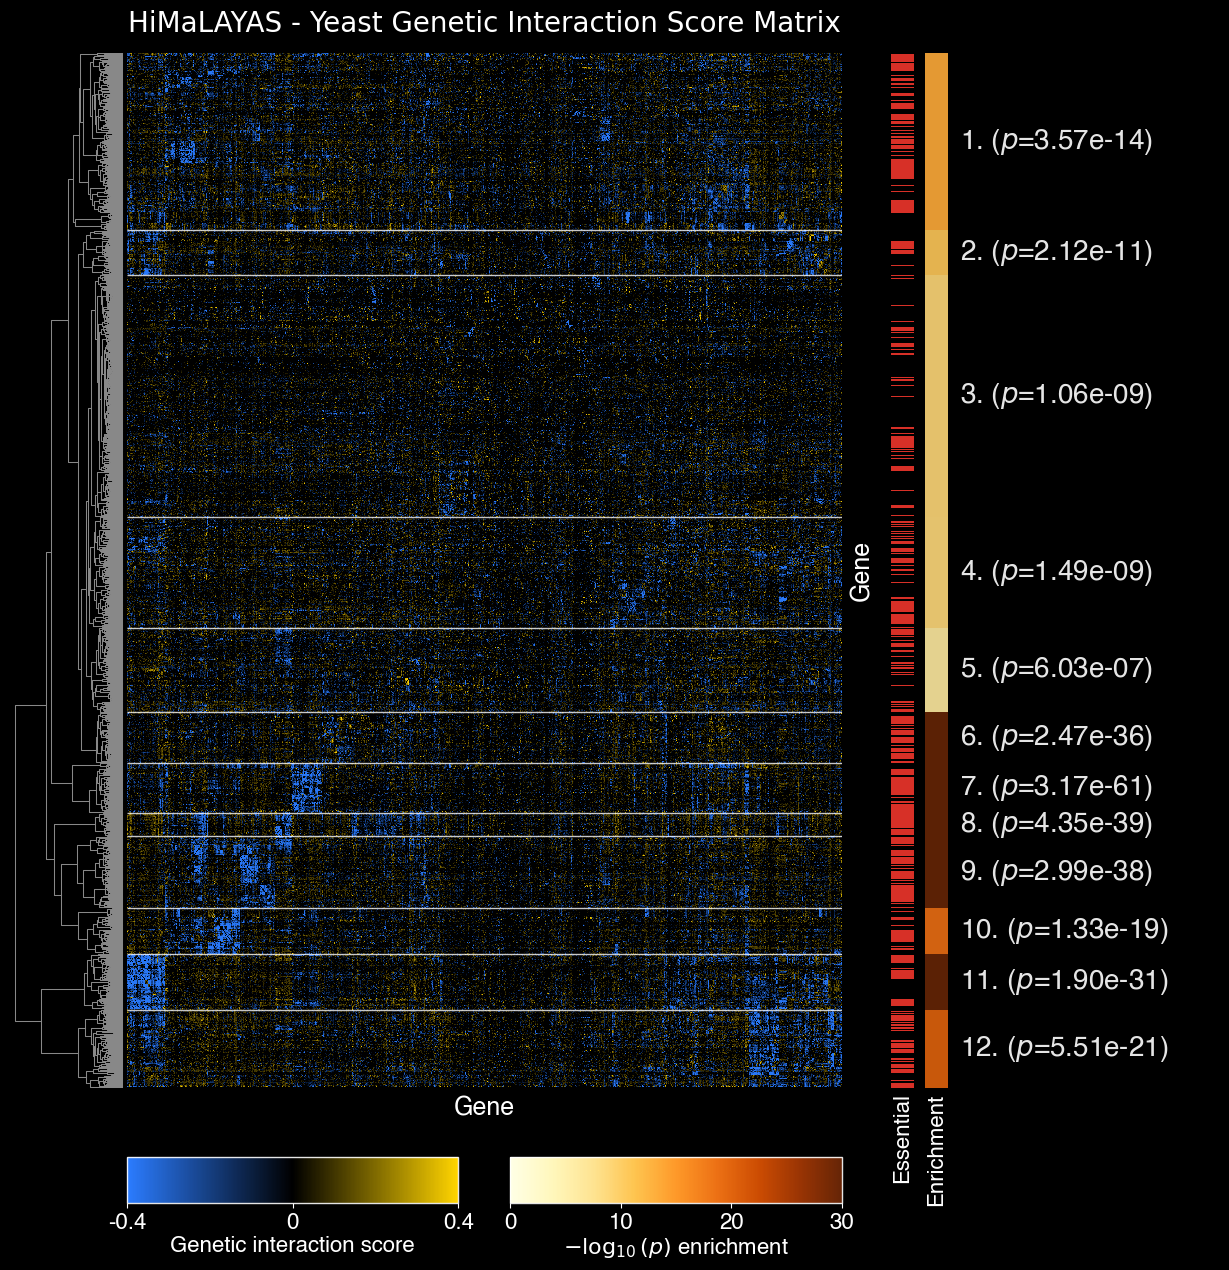

In [29]:
import numpy as np
from matplotlib.colors import Normalize
from himalayas.plot import Plotter

LABEL_COLOR = "white"
BACKGROUND_COLOR = "black"
FONT = "Helvetica"

vals = matrix.values
mask = np.isfinite(vals) & (vals != 0)
vlim = float(np.percentile(np.abs(vals[mask]), 97.5))

main_cluster_ids = sorted(cluster_labels["cluster"].astype(int).tolist())
main_overrides = {cid: f"{i}." for i, cid in enumerate(main_cluster_ids, start=1)}

plotter = (
    Plotter(results_sig)
    .set_background(color=BACKGROUND_COLOR)
    .plot_title(
        "HiMaLAYAS - Yeast Genetic Interaction Score Matrix",
        color=LABEL_COLOR,
        fontsize=20,
    )
    .plot_dendrogram(
        axes=[0.06, 0.05, 0.09, 0.90],
        data_pad=0.75,
        color="#888888",
        linewidth=0.75,
    )
    .plot_matrix(
        cmap=matrix_cmap,
        center=0,
        vmin=-vlim,
        vmax=vlim,
        outer_lw=0,
        figsize=(13, 11.5),
        subplots_adjust={"left": 0.15, "right": 0.70, "bottom": 0.05, "top": 0.95},
    )
    .plot_matrix_axis_labels(
        xlabel="Gene",
        ylabel="Gene",
        fontsize=18,
        font=FONT,
        color=LABEL_COLOR,
        xlabel_pad=6.0,
        ylabel_pad=0.008,
    )
    .plot_cluster_labels(
        term_col="term",
        cluster_col="cluster",
        weight_col="pval",
        label_mode="top_term",
        label_col="term",
        max_words=4,
        wrap_text=True,
        wrap_width=40,
        overflow="wrap",
        font=FONT,
        fontsize=20,
        color=LABEL_COLOR,
        skip_unlabeled=False,
        label_fields=("label", "p"),
        omit_words=(),
        boundary_color=LABEL_COLOR,
        boundary_lw=1,
        boundary_alpha=0.8,
        dendro_boundary_alpha=0.0,
        label_text_pad=0.012,
        label_sep_xmin=None,
        label_sep_xmax=0.5,
        label_sep_color=LABEL_COLOR,
        label_sep_lw=1,
        label_sep_alpha=0.0,
        label_gutter_color=BACKGROUND_COLOR,
        overrides=main_overrides,
        axes=[0.70, 0.05, 0.29, 0.90],
    )
    .plot_label_bar(
        values=gene_essential_map,
        mode="categorical",
        colors=gene_essential_colors,
        left_pad=0.1,
        width=0.06,
        right_pad=0.00,
        name="essentiality",
        title="Essential",
    )
    .plot_cluster_bar(
        norm=Normalize(0, 30),
        name="sigbar",
        title="Enrichment",
        width=0.06,
        left_pad=0.03,
        right_pad=0.02,
    )
    .plot_bar_labels(
        font=FONT,
        fontsize=16,
        color=LABEL_COLOR,
        pad=4,
        rotation=90,
    )
    .set_label_track_order(("essentiality", "sigbar"))
    .add_colorbar(
        name="matrix",
        cmap=matrix_cmap,
        norm=Normalize(-vlim, vlim),
        label="Genetic interaction score",
        ticks=[-vlim, 0, vlim],
    )
    .add_colorbar(
        name="enrichment",
        cmap="YlOrBr",
        norm=Normalize(0, 30),
        label=r"$-\log_{10}(p)$ enrichment",
        ticks=[0, 10, 20, 30],
    )
    .plot_colorbars(
        ncols=2,
        height=0.04,
        gap=0.06,
        hpad=0.04,
        vpad=0.00,
        fontsize=16,
        font=FONT,
        color=LABEL_COLOR,
        border_color=LABEL_COLOR,
        border_width=1.0,
        border_alpha=0.9,
        tick_decimals=2,
    )
)

plotter.show()

## Render Condensed Dendrogram

Summarize the same main hierarchy with cluster-level labels and enrichment significance.

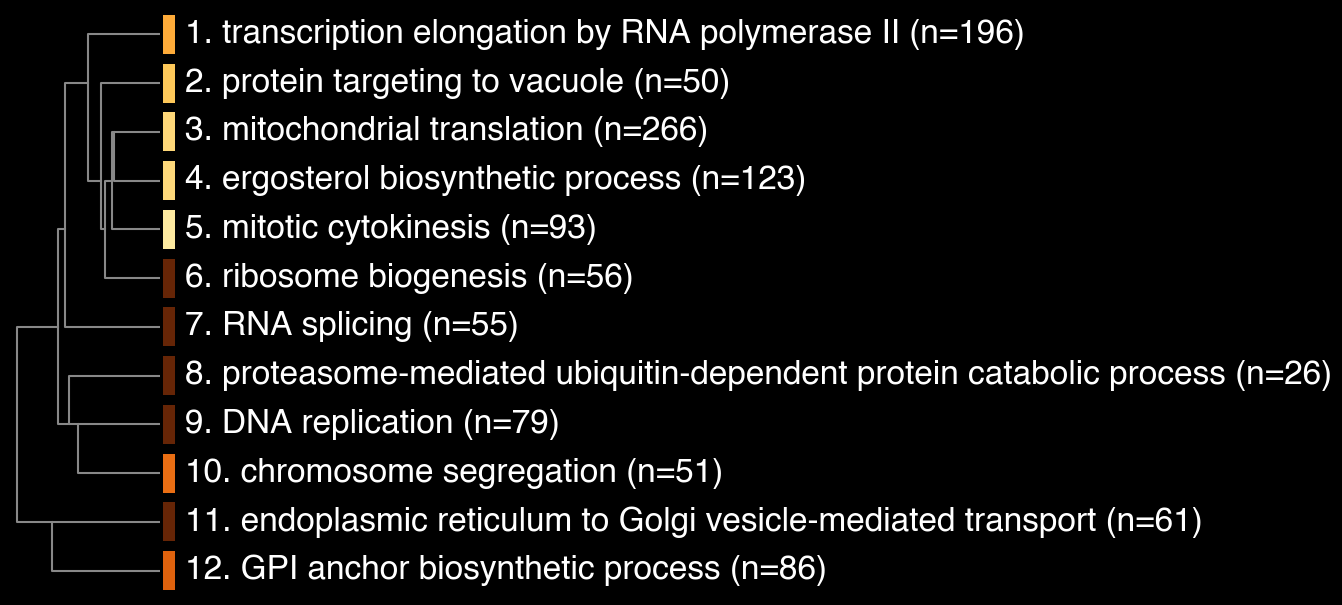

In [30]:
from himalayas.plot import plot_dendrogram_condensed

condensed_rows = cluster_labels.sort_values("cluster").reset_index(drop=True)
condensed_label_overrides = {
    int(row.cluster): f"{i}. {row.label}"
    for i, row in enumerate(condensed_rows.itertuples(index=False), start=1)
}

plot_dendrogram_condensed(
    results_sig,
    term_col="term",
    cluster_col="cluster",
    weight_col="pval",
    label_mode="top_term",
    label_col="term",
    figsize=(2.5, 6.5),
    sigbar_height=0.8,
    sigbar_width=0.05,
    sigbar_cmap="YlOrBr",
    sigbar_min_logp=0.0,
    sigbar_max_logp=30.0,
    font=FONT,
    fontsize=24,
    max_words=36,
    wrap_text=True,
    wrap_width=100,
    overflow="ellipsis",
    omit_words=(),
    label_fields=("label", "n"),
    label_overrides=condensed_label_overrides,
    label_color=LABEL_COLOR,
    label_left_pad=0.04,
    dendrogram_color="#888888",
    dendrogram_lw=1.5,
    background_color=BACKGROUND_COLOR,
)

## Nested Zoom Workflow

Use `Results.subset()` to rerun clustering and enrichment for selected clusters, then render zoomed views.

In [31]:
def run_zoom_analysis(
    *,
    results,
    cluster_id,
    go_bp,
    linkage_threshold,
    min_cluster_size=6,
    min_overlap=2,
    qval_cutoff=0.05,
):
    """Run subset clustering/enrichment for one parent cluster."""
    zoom_view = results.subset(cluster=cluster_id)
    zoom_matrix = zoom_view.matrix
    zoom_annotations = Annotations(
        go_bp,
        zoom_matrix,
    )
    zoom_analysis = (
        Analysis(zoom_matrix, zoom_annotations)
        .cluster(
            linkage_method="ward",
            linkage_metric="euclidean",
            linkage_threshold=linkage_threshold,
            min_cluster_size=min_cluster_size,
        )
        .enrich(
            min_overlap=min_overlap,
            background=results.matrix,
        )
        .finalize(
            col_cluster=True,
            add_qvalues=True,
        )
    )
    zoom_results = zoom_analysis.results
    zoom_results_sig = zoom_results.filter(f"qval <= {qval_cutoff}")
    return zoom_matrix, zoom_results, zoom_results_sig


def render_zoom_plot(
    *,
    cluster_id,
    zoom_matrix,
    zoom_results_sig,
    figsize,
    colorbar_height,
    colorbar_gap,
):
    """Render one zoomed matrix panel with shared styling and tracks."""
    label_color = "white"
    background_color = "black"

    vals = zoom_matrix.values
    mask = np.isfinite(vals) & (vals != 0)
    vlim = float(np.percentile(np.abs(vals[mask]), 98))

    (
        Plotter(zoom_results_sig)
        .set_background(color=background_color)
        .plot_title(
            f"Yeast Genetic Interaction Score Matrix (Cluster {cluster_id})",
            color=label_color,
            fontsize=20,
        )
        .plot_dendrogram(
            axes=[0.06, 0.05, 0.09, 0.90],
            data_pad=0.75,
            color="#888888",
            linewidth=0.75,
        )
        .plot_matrix(
            cmap=matrix_cmap,
            center=0,
            vmin=-vlim,
            vmax=vlim,
            figsize=figsize,
            subplots_adjust={
                "left": 0.15,
                "right": 0.70,
                "bottom": 0.05,
                "top": 0.95,
            },
        )
        .plot_matrix_axis_labels(
            xlabel="Gene",
            ylabel="Gene",
            font=FONT,
            fontsize=20,
            color=label_color,
            xlabel_pad=8,
            ylabel_pad=0.012,
        )
        .plot_cluster_labels(
            term_col="term",
            cluster_col="cluster",
            weight_col="pval",
            label_mode="top_term",
            label_col="term",
            max_words=24,
            wrap_text=True,
            wrap_width=40,
            overflow="wrap",
            font=FONT,
            fontsize=20,
            color=label_color,
            skip_unlabeled=False,
            label_fields=("label", "n", "p"),
            omit_words=(),
            boundary_color=label_color,
            boundary_lw=1,
            boundary_alpha=0.8,
            dendro_boundary_alpha=0.0,
            label_text_pad=0.012,
            label_sep_xmin=None,
            label_sep_xmax=1.0,
            label_sep_color=LABEL_COLOR,
            label_sep_lw=1,
            label_sep_alpha=0.0,
            label_gutter_color=BACKGROUND_COLOR,
            axes=[0.70, 0.05, 0.29, 0.90],
        )
        .plot_label_bar(
            values=gene_essential_map,
            mode="categorical",
            colors=gene_essential_colors,
            left_pad=0.12,
            width=0.06,
            right_pad=0.00,
            name="essentiality",
            title="Essential",
        )
        .plot_cluster_bar(
            norm=Normalize(0, 30),
            name="sigbar",
            title="Enrichment",
            width=0.06,
            left_pad=0.03,
            right_pad=0.02,
        )
        .plot_bar_labels(
            font=FONT,
            fontsize=16,
            color=label_color,
            pad=4,
            rotation=90,
        )
        .set_label_track_order(("essentiality", "sigbar"))
        .add_colorbar(
            name="matrix",
            cmap=matrix_cmap,
            norm=Normalize(-vlim, vlim),
            label="Genetic interaction score",
            ticks=[-vlim, 0, vlim],
        )
        .add_colorbar(
            name="enrichment",
            cmap="YlOrBr",
            norm=Normalize(0, 30),
            label=r"$-\log_{10}(p)$ enrichment",
            ticks=[0, 10, 20, 30],
        )
        .plot_colorbars(
            ncols=2,
            height=colorbar_height,
            gap=colorbar_gap,
            hpad=0.04,
            vpad=0.00,
            fontsize=16,
            font=FONT,
            color=label_color,
            border_color=label_color,
            border_width=1.0,
            border_alpha=0.9,
            tick_decimals=2,
        )
        .show()
    )


def run_zoom_cluster(
    *,
    cluster_id,
    linkage_threshold,
    figsize,
    colorbar_height,
    colorbar_gap,
):
    """Execute zoom analysis and render one cluster-specific panel."""
    zoom_matrix, _, zoom_results_sig = run_zoom_analysis(
        results=results,
        cluster_id=cluster_id,
        go_bp=go_bp,
        linkage_threshold=linkage_threshold,
    )
    render_zoom_plot(
        cluster_id=cluster_id,
        zoom_matrix=zoom_matrix,
        zoom_results_sig=zoom_results_sig,
        figsize=figsize,
        colorbar_height=colorbar_height,
        colorbar_gap=colorbar_gap,
    )

### Zoom Cluster 7

Run zoom analysis and render the Cluster 7 view.

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 1039/1095 annotations with no overlap to matrix labels
  warn(


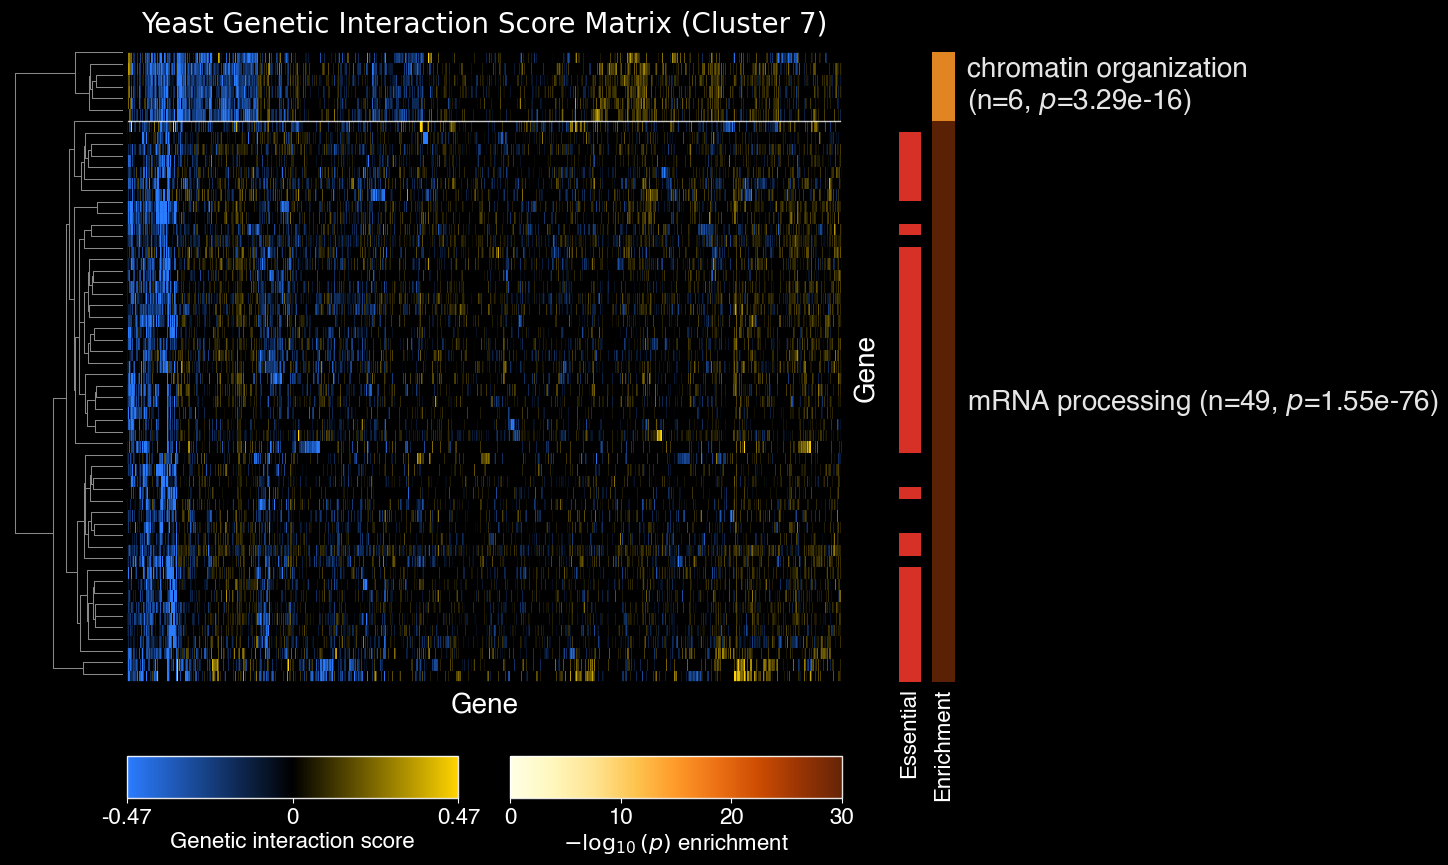

In [32]:
# Run zoom analysis and render Cluster 7.
run_zoom_cluster(
    cluster_id=7,
    linkage_threshold=6,
    figsize=(13, 7),
    colorbar_height=0.06,
    colorbar_gap=0.105,
)

### Zoom Cluster 8

Run zoom analysis and render the Cluster 8 view.

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 1062/1095 annotations with no overlap to matrix labels
  warn(


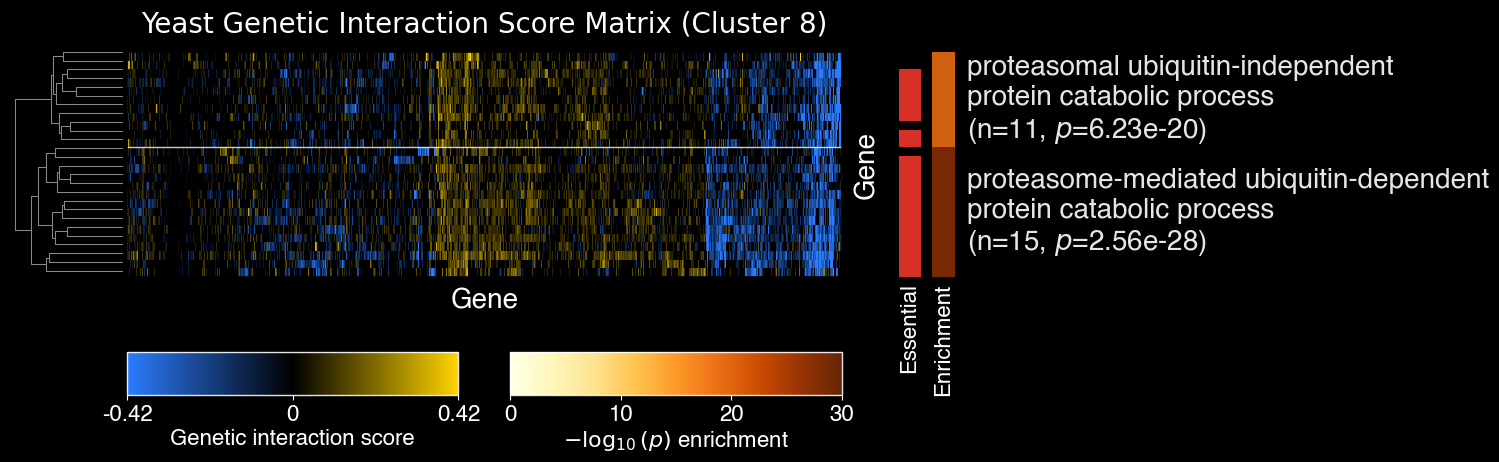

In [33]:
# Run zoom analysis and render Cluster 8.
run_zoom_cluster(
    cluster_id=8,
    linkage_threshold=5,
    figsize=(13, 2.5),
    colorbar_height=0.17,
    colorbar_gap=0.3,
)

### Zoom Cluster 9

Run zoom analysis and render the Cluster 9 view.

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 932/1095 annotations with no overlap to matrix labels
  warn(


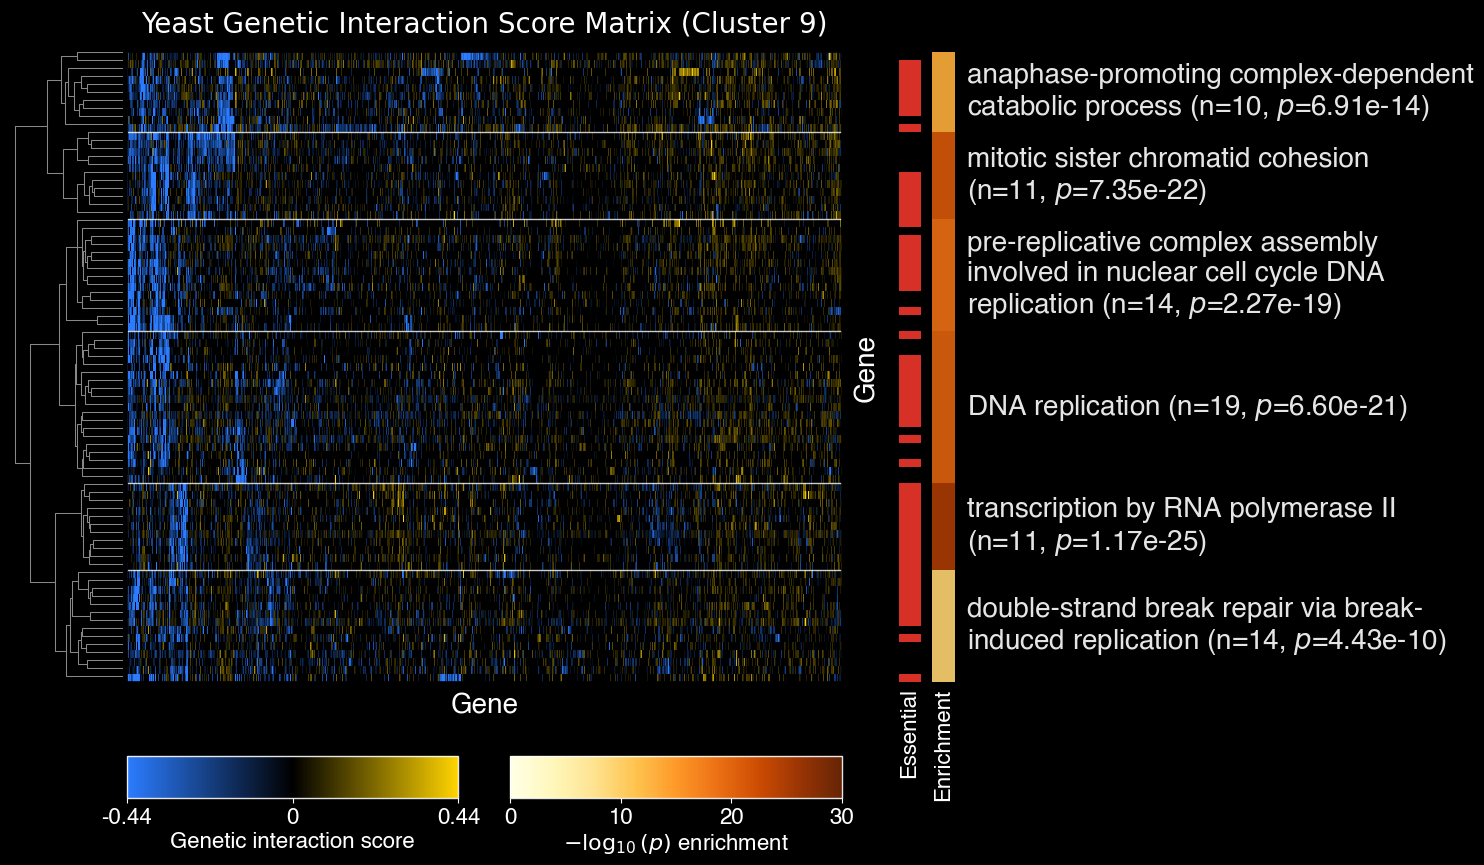

In [34]:
# Run zoom analysis and render Cluster 9.
run_zoom_cluster(
    cluster_id=9,
    linkage_threshold=6,
    figsize=(13, 7),
    colorbar_height=0.06,
    colorbar_gap=0.105,
)